# Logistic Regression on basic numerical data

# Relevant Imports

In [1]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



# Load and preprocess data

In [2]:
# Load the dataset
file_path = '../../../dataset_final/Daily_Financial_News/QQQ/QQQ_numerical.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


         Date    Open   Close    High      Volume
0  2020-06-09  240.66  243.30  244.17  35046300.0
1  2020-06-08  239.53  241.55  241.67  32937300.0
2  2020-06-05  236.22  239.69  240.30  47365600.0
3  2020-06-04  236.33  235.02  237.78  38716100.0
4  2020-06-03  236.25  236.69  237.47  37228700.0


In [3]:
# Check for missing values
print(data.isnull().sum())

# Summary statistics of the dataset
print(data.describe())


Date      0
Open      0
Close     0
High      0
Volume    0
dtype: int64
              Open        Close         High        Volume
count  2324.000000  2324.000000  2324.000000  2.324000e+03
mean    117.820676   117.854441   118.555004  3.847189e+07
std      47.653211    47.692191    48.031433  2.197806e+07
min      50.410000    50.020000    51.240000  7.079300e+06
25%      74.235000    74.242500    74.540000  2.391680e+07
50%     108.075000   108.065000   108.660000  3.260090e+07
75%     159.547500   159.562500   161.365000  4.617612e+07
max     240.660000   243.300000   244.170000  2.141118e+08


In [4]:
# Drop the current index and reset to default integer index
data = data.reset_index(drop=True)

# Sort the DataFrame by the 'Dates' column in ascending order
data = data.sort_values(by='Date', ascending=True)

data.head()

,Date,Open,Close,High,Volume
2323,2011-03-16,55.02,54.15,55.34,176507700.0
2322,2011-03-17,55.00,54.65,55.24,94434500.0
2321,2011-03-18,55.22,54.45,55.22,94887200.0
2320,2011-03-21,55.27,55.50,55.77,57423000.0
2319,2011-03-22,55.58,55.40,55.61,36162100.0


# Define features and target value

In [5]:
# Calculate next-day return
data['Movement'] = ((data['Open'].shift(-1) - data['Close']) / data['Close'])

# Shift Movement to align with current day
data['Movement'] = data['Movement'].shift(1)

# Drop the last row because there's no next day to compare
data = data.dropna(subset=['Movement'])

# Convert Movement into binary (1 for up if Movement > 0, else 0)
data['Movement'] = (data['Movement'] > 0).astype(int)

# Check the distribution of the target variable
print(data['Movement'].value_counts().sort_index())

Movement
0    1026
1    1297
Name: count, dtype: int64


In [6]:
# Calculate daily returns (in percentage)
data['Daily_Return'] = data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
data = data.dropna(subset=['Volatility'])

In [7]:
# Create lagged features to avoid data leakage
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Daily_Return_lag1'] = data['Daily_Return'].shift(1)
data['Volatility_lag1'] = data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
data = data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1'])


In [8]:
data.tail(20)


,Date,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
19,2020-05-12,227.49,222.11,228.10,41054100.0,1,-2.093802,1.434742,226.86,227.92,35714100.0,0.889442,0.308307
18,2020-05-13,222.66,219.33,224.61,65521200.0,1,-1.251632,1.602329,222.11,228.10,41054100.0,-2.093802,1.434742
17,2020-05-14,217.97,221.83,221.86,51549300.0,0,1.139835,1.574686,219.33,224.61,65521200.0,-1.251632,1.602329
16,2020-05-15,218.77,223.27,223.33,55747200.0,0,0.649146,1.446835,221.83,221.86,51549300.0,1.139835,1.574686
15,2020-05-18,226.27,227.42,228.67,42398100.0,1,1.858736,1.666421,223.27,223.33,55747200.0,0.649146,1.446835
14,2020-05-19,227.69,226.86,229.85,36237300.0,1,-0.246240,1.212267,227.42,228.67,42398100.0,1.858736,1.666421
13,2020-05-20,229.50,231.38,231.75,37417000.0,1,1.992418,0.920198,226.86,229.85,36237300.0,-0.246240,1.212267
12,2020-05-21,231.44,228.86,232.13,43642900.0,1,-1.089117,1.331302,231.38,231.75,37417000.0,1.992418,0.920198
11,2020-05-22,228.44,229.66,229.86,28762400.0,0,0.349559,1.337122,228.86,232.13,43642900.0,-1.089117,1.331302
10,2020-05-26,233.36,229.03,233.57,33055300.0,1,-0.274319,1.151817,229.66,229.86,28762400.0,0.349559,1.337122


In [9]:
data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')

In [10]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 
                        'Daily_Return_lag1', 'Volatility_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


Open                 0.035512
Close_lag1           0.023141
High_lag1            0.023452
Volume_lag1         -0.009420
Daily_Return_lag1   -0.039847
Volatility_lag1     -0.006006
Name: Movement, dtype: float64


In [11]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']
X = data[features]
y = data['Movement']

# Inspect the feature set
print(X.head())
print(y.head())


       Open  Close_lag1  High_lag1  Volume_lag1  Daily_Return_lag1  \
2316  56.88       56.70      56.81   69502400.0           1.795332   
2315  57.09       56.84      57.22   74131100.0           0.246914   
2314  56.40       56.52      57.09   37824000.0          -0.562984   
2313  57.36       57.08      57.08   47994800.0           0.990800   
2312  57.25       57.34      57.43   44935900.0           0.455501   

      Volatility_lag1  
2316         1.076473  
2315         0.945430  
2314         0.901288  
2313         0.874948  
2312         0.877285  
2316    1
2315    1
2314    0
2313    1
2312    0
Name: Movement, dtype: int64


# Splitting and scaling the data

In [12]:
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Ensure correct datetime format
data.set_index('Date', inplace=True)
print(data.index)


DatetimeIndex(['2011-03-25', '2011-03-28', '2011-03-29', '2011-03-30',
               '2011-03-31', '2011-04-01', '2011-04-04', '2011-04-05',
               '2011-04-06', '2011-04-07',
               ...
               '2020-05-27', '2020-05-28', '2020-05-29', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-08', '2020-06-09'],
              dtype='datetime64[ns]', name='Date', length=2317, freq=None)


In [13]:
X.index = data.index
print(X.index)

DatetimeIndex(['2011-03-25', '2011-03-28', '2011-03-29', '2011-03-30',
               '2011-03-31', '2011-04-01', '2011-04-04', '2011-04-05',
               '2011-04-06', '2011-04-07',
               ...
               '2020-05-27', '2020-05-28', '2020-05-29', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-08', '2020-06-09'],
              dtype='datetime64[ns]', name='Date', length=2317, freq=None)


In [14]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
# Initialize lists to store train and test years
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]
    
    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)
    
    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2011-03-25 to 2012-10-04
Test Dates: 2012-10-05 to 2014-04-22
--------------------------------------------------
Fold 2:
Train Dates: 2011-03-25 to 2014-04-22
Test Dates: 2014-04-23 to 2015-10-30
--------------------------------------------------
Fold 3:
Train Dates: 2011-03-25 to 2015-10-30
Test Dates: 2015-11-02 to 2017-05-15
--------------------------------------------------
Fold 4:
Train Dates: 2011-03-25 to 2017-05-15
Test Dates: 2017-05-16 to 2018-11-23
--------------------------------------------------
Fold 5:
Train Dates: 2011-03-25 to 2018-11-23
Test Dates: 2018-11-26 to 2020-06-09
--------------------------------------------------


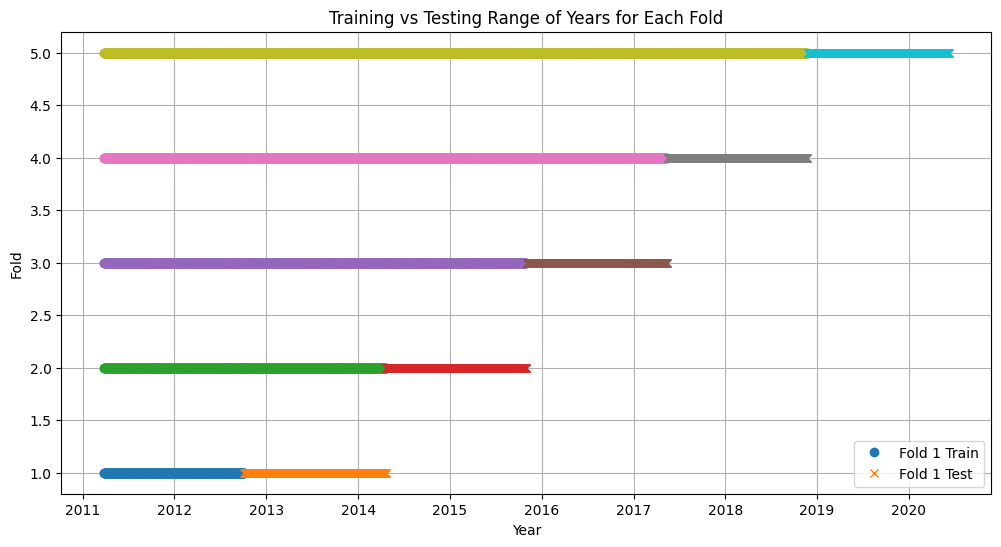

In [15]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Model training and evaluation



Fold 1 Confusion Matrix:
[[106  52]
 [ 12 216]]


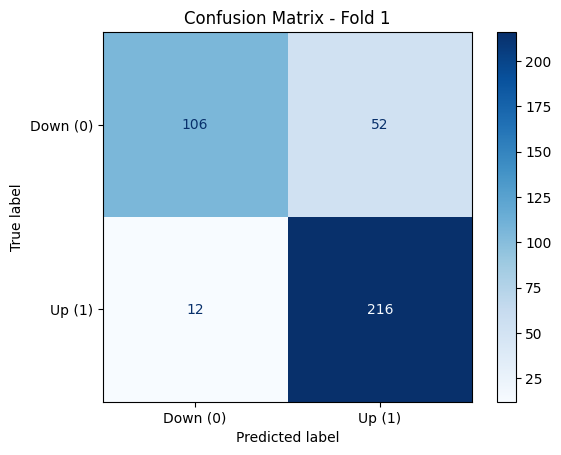

Fold 1 Accuracy: 0.83
--------------------------------------------------

Fold 2 Confusion Matrix:
[[ 13 165]
 [  0 208]]


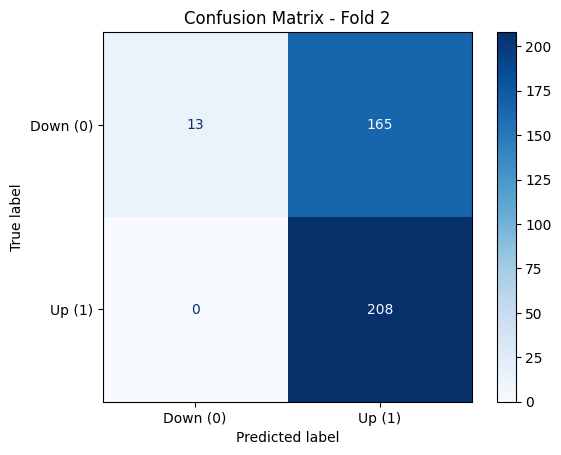

Fold 2 Accuracy: 0.57
--------------------------------------------------

Fold 3 Confusion Matrix:
[[ 29 143]
 [  0 214]]


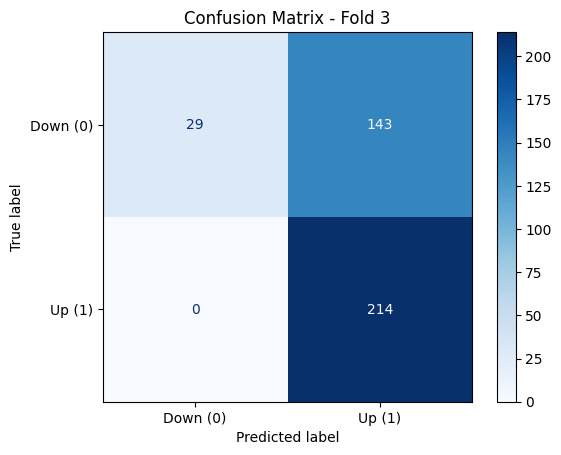

Fold 3 Accuracy: 0.63
--------------------------------------------------

Fold 4 Confusion Matrix:
[[ 38 127]
 [  0 221]]


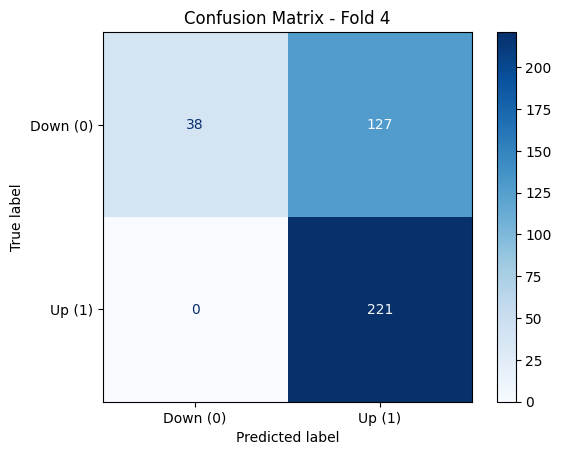

Fold 4 Accuracy: 0.67
--------------------------------------------------

Fold 5 Confusion Matrix:
[[ 49 114]
 [  3 220]]


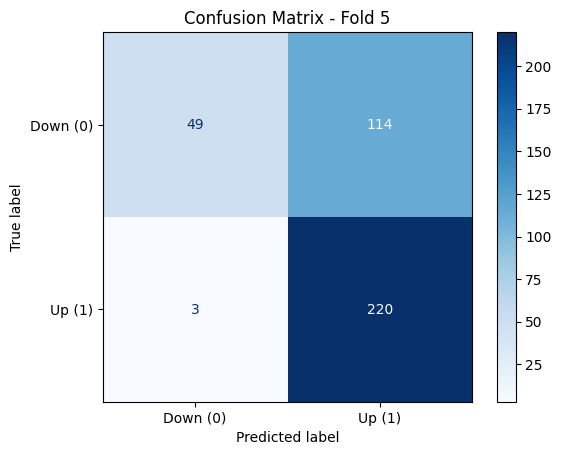

Fold 5 Accuracy: 0.70
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.68
Precision: 0.65
Recall: 0.99
F1-Score: 0.78
ROC-AUC: 0.93


In [16]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()
    
    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


# Evaluation on balanced data

Fold 1 - Balanced Class Distribution:
Movement
0    189
1    189
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[116  42]
 [ 21 207]]


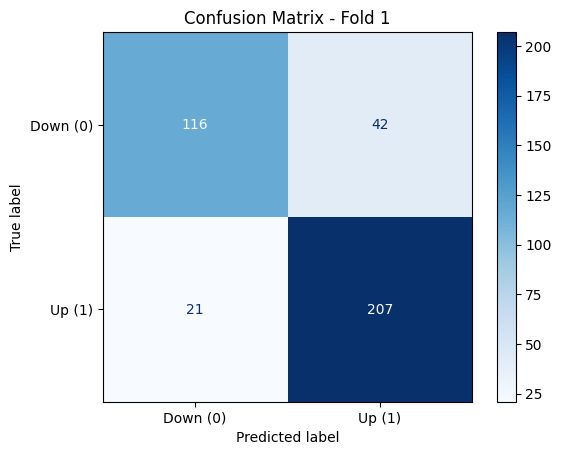

Fold 1 Accuracy: 0.84
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    347
1    347
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[ 23 155]
 [  0 208]]


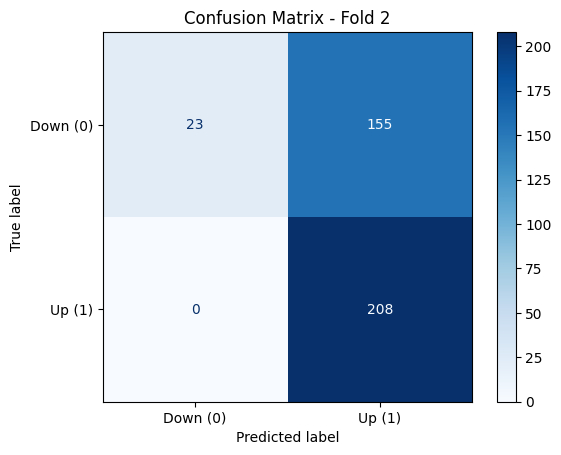

Fold 2 Accuracy: 0.60
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    525
1    525
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[ 82  90]
 [ 11 203]]


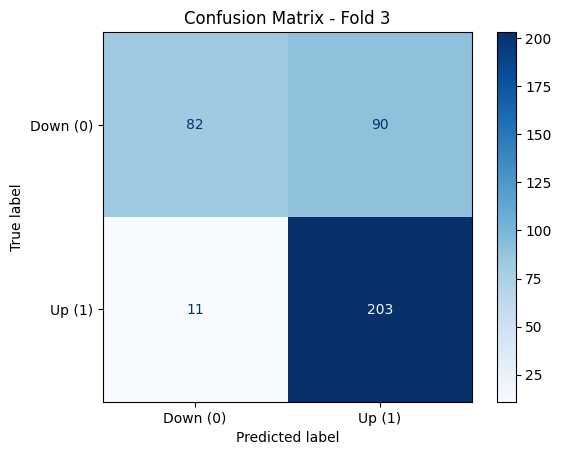

Fold 3 Accuracy: 0.74
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    697
1    697
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[ 60 105]
 [  0 221]]


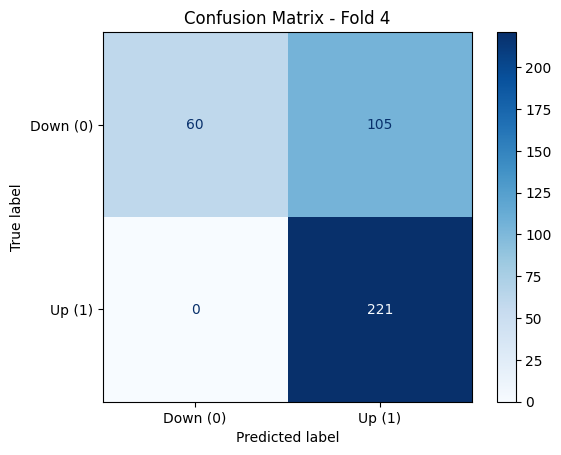

Fold 4 Accuracy: 0.73
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    862
1    862
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[123  40]
 [ 15 208]]


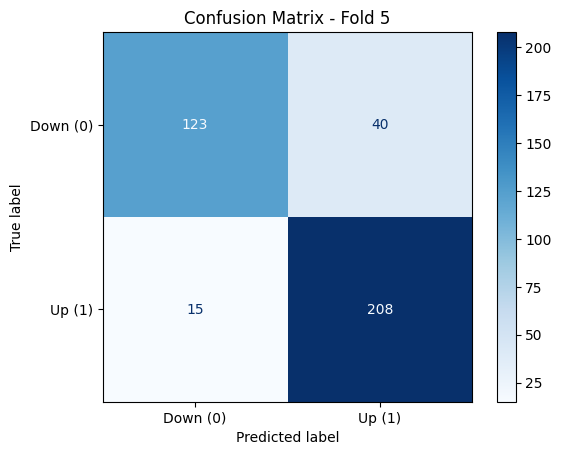

Fold 5 Accuracy: 0.86
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.75
Precision: 0.72
Recall: 0.96
F1-Score: 0.82
ROC-AUC: 0.92


In [17]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)
    
    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


In [18]:
data.to_csv('../../../dataset_final/Daily_Financial_News/QQQ/QQQ_numerical_LR.csv')